## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

## Get data

In [3]:
x_train_raw = pd.read_csv('../data/X_train.csv').drop('id', axis=1)
y_train_raw = pd.read_csv('../data/y_train.csv').drop('id', axis=1)

In [4]:
x_train_raw.shape

(4800, 1000)

In [5]:
y_train_raw.shape

(4800, 1)

(array([ 600.,    0.,    0.,    0.,    0., 3600.,    0.,    0.,    0.,
         600.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

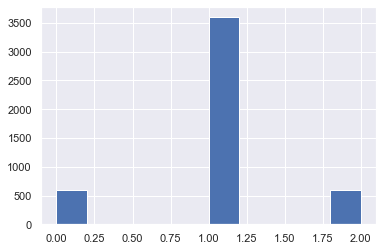

In [6]:
plt.hist(y_train_raw.values.ravel())

In [7]:
x_train_raw.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x990,x991,x992,x993,x994,x995,x996,x997,x998,x999
0,-1.099144,0.918165,-1.227394,0.887061,1.182734,-0.371802,-0.127331,1.201702,1.825839,2.944655,...,-1.111422,1.566261,-1.656656,-0.412988,2.803183,-3.253815,-2.042599,3.497246,-1.275422,2.440708
1,0.366477,0.933802,0.061234,0.430073,1.029673,-0.613771,0.364698,1.140867,0.182811,-0.344876,...,-0.672386,-0.003721,-0.496326,0.672818,-0.546066,-0.227112,0.291441,-0.150495,0.156421,0.714252
2,-0.425879,-0.802152,0.002718,0.820036,1.490237,-0.888121,0.769524,1.059020,0.854806,-0.077359,...,-1.031358,-0.085724,-0.557461,-0.091904,-0.123858,0.387162,1.031941,0.766522,0.339105,-0.046364
3,0.822922,-0.843041,-0.734624,-0.000040,0.123783,-1.777226,0.364601,0.425521,1.265122,0.734897,...,-0.118974,1.271367,-1.518161,-0.315441,0.218074,-1.880067,-0.495170,1.418946,-0.201938,1.475484
4,-0.285342,-0.641116,0.436524,-0.618663,0.319982,-1.160489,0.528379,0.337300,-0.156210,-0.756133,...,-0.997750,-1.008573,-0.404263,0.304188,0.313034,-0.514287,0.701526,0.473238,-0.046099,0.492881


## Split data

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_raw, y_train_raw, test_size = 0.2)

## Upsample training data (with SMOTE)

In [9]:
y_counts = y_train.y.value_counts()
y_counts

1    2870
2     495
0     475
Name: y, dtype: int64

In [10]:
# upsample all but the majority class
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='not majority')
x_sm, y_sm = smote.fit_sample(x_train, y_train)

/Users/elrich/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# check number of rows for each class
[len([y for y in y_sm if y ==0]),len([y for y in y_sm if y ==1]),len([y for y in y_sm if y ==2])]

[2870, 2870, 2870]

## Fit Model

In [12]:
from sklearn.metrics import balanced_accuracy_score
def score(true, pred):
    return balanced_accuracy_score(true, pred)

### Random forests

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
rf = RandomForestClassifier(max_features=round(len(x_sm[0])/3))
rf.fit(x_sm, y_sm)
y_sm_pred = rf.predict(x_sm)
train_score = score(y_sm, y_sm_pred)
print('train score: ', train_score)
y_val_pred = rf.predict(x_val)
test_score = score(y_val, y_val_pred)
print('test score ', test_score)

/Users/elrich/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train score:  0.9987224157955866
test score  0.5514163948684496


In [ ]:
len(x_sm[0])

In [ ]:
y_val_pred

## Output predictions

In [ ]:
x_test_raw = pd.read_csv('../data/X_test.csv').drop('id', axis=1)
def output_pred(model, name):
    y_test_pred = rf.predict(x_test_raw)
    output = pd.DataFrame({'id':[float(i) for i in range(0, len(x_test_raw))], 'y': y_test_pred})
    output.to_csv(name,index=False)

In [ ]:
output_pred(rf, 'rf.csv')

## Cross validation

In [51]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
import time

In [98]:
# Get balanced accuracy score
def score(true, pred):
    return balanced_accuracy_score(true, pred)

# Oversample using SMOTE
def oversample(x_data, y_data):
    smote = SMOTE(ratio='not majority')
    return smote.fit_sample(x_data, y_data)

# Oversample and fit model for a CV split
def run_fold(x_train, y_train, x_test, y_test, model):
    # Oversample data
    x_train_sm, y_train_sm = oversample(x_train, y_train)
    # Fit model
    model.fit(x_train_sm, y_train_sm)
    y_train_pred = rf.predict(x_train_sm)
    train_score = score(y_train_sm, y_train_pred)
    y_test_pred = rf.predict(x_test)
    test_score = score(y_test, y_test_pred)
    return test_score, train_score

def cross_validate(x_data, y_data, model):
    # Split data into folds
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True)
    folds = kf.split(x_data)
    test_scores = []
    train_scores = []
    times = []
    split = 0
    for train_index, test_index in folds:
        split += 1
        print('Running split {}/{}'.format(split, n_splits))
        x_train = x_data[train_index]
        y_train = y_data[train_index]
        x_test = x_data[test_index]
        y_test = y_data[test_index]
        start_time = time.time()
        test_score, train_score, y_test_pred = run_fold(x_train, y_train, x_test, y_test, model)
        end_time = time.time()
        total_time = round(end_time-start_time, ndigits=0)
        test_scores.append(test_score)
        train_scores.append(train_score)
        times.append(end_time-start_time)
        print('Test score = {}\nTrain score = {}\nTime = {}s\n'.format(test_score, train_score, total_time))
    print('Average test score: {}\nAverage train score: {}\nTotal time: {}s'.format(np.mean(test_scores), np.mean(train_scores), np.sum(times)))
    return test_scores, train_scores, times

In [96]:
x_data = x_train_raw.values
y_data = y_train_raw.values.ravel()

In [97]:
test_scores, train_scores, times = cross_validate(x_data, y_data, rf)

Running split 1/10
Test score = 0.5516490792468446
Train score = 0.9980464733703475
Time = 26.0s

Running split 2/10
Test score = 0.5584606246859677
Train score = 0.9975285758418287
Time = 28.0s

Running split 3/10
Test score = 0.5399975797944404
Train score = 0.9980446639909437
Time = 27.0s

Running split 4/10
Test score = 0.5509251222075014
Train score = 0.9974192216372457
Time = 27.0s

Running split 5/10
Test score = 0.58938183322529
Train score = 0.9984572662758407
Time = 27.0s

Running split 6/10
Test score = 0.5733077905491698
Train score = 0.9984567901234568
Time = 28.0s

Running split 7/10
Test score = 0.5843920803806191
Train score = 0.9980518814723675
Time = 27.0s

Running split 8/10
Test score = 0.534294996688101
Train score = 0.9985587811406219
Time = 27.0s

Running split 9/10
Test score = 0.5939106192782543
Train score = 0.9966038900895339
Time = 26.0s

Running split 10/10
Test score = 0.5406952247191011
Train score = 0.9980476777640773
Time = 27.0s

Average test score: 0.